# Telecommunications Customer Churn Predictions
#### Implemented by Ghazal E Ashar

_This project aims to tackle the challenge of customer churn within a telecommunications company by leveraging data analysis and predictive modeling techniques. The primary objective is to develop a robust model capable of identifying customers who are likely to churn, thereby enabling targeted retention strategies. To achieve this, the project is structured into two distinct modules: **Python** for data preprocessing and model development, **AI Algorithms** for building and tuning predictive models. Another module used is **SQL** for efficient data management and querying. Each module addresses a critical component of the overall analysis, ensuring a comprehensive approach to understanding and predicting customer churn._

## Module 1: Python

In [1]:
# Import necessary libraries

#!pip show numpy pandas scikit-learn matplotlib seaborn 
#!pip install shap

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#Data visualization and model metrics librariies 
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle
import joblib

C:\Users\ghaza\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Task 1.1: Data Preprocessing

#### Load the dataset and inspect the data
Load the dataset and display the first few rows to understand its structure and contents.

In [2]:
data = pd.read_csv('Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Converting `TotalCharges` to Numeric Format

This step ensures that the `TotalCharges` column, which might contain non-numeric values, is converted to a numeric format. Any non-numeric values are coerced to `NaN` to handle inconsistencies in the data.

In [3]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

#### Handling Missing Values in `TotalCharges`
This step calculates the mean of the `TotalCharges` column and fills any missing values (`NaN`) with this mean to ensure completeness of the data.

In [4]:
mean_total_charges = data['TotalCharges'].mean()
data['TotalCharges'].fillna(mean_total_charges, inplace=True)

In [5]:
# uncomment if exporting dataset for sql purposes

data = data.reset_index()

In [6]:
sqlData = data.drop(['Churn', 'customerID', 'gender', 'PhoneService', 'Dependents', 'StreamingTV', 'DeviceProtection', 'Partner' ], axis = 1)
sqlData.to_csv('TP-copyy.csv', index=False)

#### Encoding Categorical Variables

The `feature_columns` variable is created to select all columns from the dataset `data` except for 'Churn' and 'customerID'. 
1. This is achieved using a list comprehension, iterating over `data.columns` and excluding columns named 'Churn' and 'customerID'. 
2. The resulting list `feature_columns` contains the names of columns that will be used as features in subsequent data analysis or modeling tasks.

In [7]:
feature_columns = [col for col in data.columns if col != 'Churn' and col != 'customerID']
feature_columns

['index',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

The `label_encoders` dictionary is initialized to store `LabelEncoder` objects for categorical columns in the dataset `data`. 
1. The loop iterates through each column in `feature_columns`.
2. If a column's data type is 'object', indicating it contains categorical data, a `LabelEncoder` is instantiated and used to transform the categorical values into numeric labels.
3. The transformed data replaces the original column values in `data`, and the `LabelEncoder` instance is stored in `label_encoders` with the column name as the key.

This process prepares categorical data for machine learning models that require numeric inputs.

In [8]:
label_encoders = {}
for column in feature_columns:
    if data[column].dtype == 'object':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le

data.head()

,index,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,7590-VHVEG,0,0,1,0,1,0,1,0,...,0,0,0,0,0,1,2,29.85,29.85,No
1,1,5575-GNVDE,1,0,0,0,34,1,0,0,...,2,0,0,0,1,0,3,56.95,1889.50,No
2,2,3668-QPYBK,1,0,0,0,2,1,0,0,...,0,0,0,0,0,1,3,53.85,108.15,Yes
3,3,7795-CFOCW,1,0,0,0,45,0,1,0,...,2,2,0,0,1,0,0,42.30,1840.75,No
4,4,9237-HQITU,0,0,0,0,2,1,0,1,...,0,0,0,0,0,1,2,70.70,151.65,Yes


#### Normalize/Standardize the data

Normalize the numeric columns (`tenure`, `MonthlyCharges`, `TotalCharges`) using `StandardScaler` to ensure that the data is on a similar scale.

The following columns are scaled: 

- Tenure: This column represents the number of months a customer has stayed with the company. The range of values can vary widely, and scaling ensures that it is comparable to other features.

- MonthlyCharges: This column represents the amount charged to the customer monthly. Different customers can have widely varying monthly charges, and scaling helps normalize this feature.

- TotalCharges: This column represents the total charges a customer has incurred. Given that total charges can be significantly larger than monthly charges or tenure, it is essential to scale this feature to prevent it from dominating the model.

In [9]:
scaler = StandardScaler()
numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
data.head()

,index,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,7590-VHVEG,0,0,1,0,-1.280248,0,1,0,...,0,0,0,0,0,1,2,-1.161694,-0.994194,No
1,1,5575-GNVDE,1,0,0,0,0.064303,1,0,0,...,2,0,0,0,1,0,3,-0.260878,-0.173740,No
2,2,3668-QPYBK,1,0,0,0,-1.239504,1,0,0,...,0,0,0,0,0,1,3,-0.363923,-0.959649,Yes
3,3,7795-CFOCW,1,0,0,0,0.512486,0,1,0,...,2,2,0,0,1,0,0,-0.747850,-0.195248,No
4,4,9237-HQITU,0,0,0,0,-1.239504,1,0,1,...,0,0,0,0,0,1,2,0.196178,-0.940457,Yes


In [10]:
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

### Task 1.2: Exploratory Data Analysis (EDA)

#### Data Statistics

Generate a summary of statistical measures (such as count, mean, std, min, 25th percentile, 50th percentile, 75th percentile, and max) for numerical columns in the `data` dataset. 

This summary helps in understanding the distribution and central tendencies of numeric data, which is crucial for data analysis and modeling tasks.

In [11]:
print("Descriptive Statistics:")
print(data.describe())

Descriptive Statistics:
             index       gender  SeniorCitizen      Partner   Dependents  \
count  7032.000000  7032.000000    7032.000000  7032.000000  7032.000000   
mean   3515.500000     0.504693       0.162400     0.482509     0.298493   
std    2030.107879     0.500014       0.368844     0.499729     0.457629   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%    1757.750000     0.000000       0.000000     0.000000     0.000000   
50%    3515.500000     1.000000       0.000000     0.000000     0.000000   
75%    5273.250000     1.000000       0.000000     1.000000     1.000000   
max    7031.000000     1.000000       1.000000     1.000000     1.000000   

             tenure  PhoneService  MultipleLines  InternetService  \
count  7.032000e+03   7032.000000    7032.000000      7032.000000   
mean  -1.126643e-16      0.903299       0.940557         0.872582   
std    1.000071e+00      0.295571       0.948627         0.737271   
min   -1.280248

#### Data Information

Generate a concise summary of the `data` dataframe. 

It provides information about the dataset, including the number of entries (rows), the number of columns, each column's name, data type, and the count of non-null values. 

This summary is valuable for understanding the structure and completeness of the dataset, identifying any missing values, and verifying the data types of each feature, which are essential steps in data preprocessing and analysis.

In [12]:
print("Descriptive Information:")
print(data.info())

Descriptive Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             7032 non-null   int64  
 1   customerID        7032 non-null   object 
 2   gender            7032 non-null   int32  
 3   SeniorCitizen     7032 non-null   int64  
 4   Partner           7032 non-null   int32  
 5   Dependents        7032 non-null   int32  
 6   tenure            7032 non-null   float64
 7   PhoneService      7032 non-null   int32  
 8   MultipleLines     7032 non-null   int32  
 9   InternetService   7032 non-null   int32  
 10  OnlineSecurity    7032 non-null   int32  
 11  OnlineBackup      7032 non-null   int32  
 12  DeviceProtection  7032 non-null   int32  
 13  TechSupport       7032 non-null   int32  
 14  StreamingTV       7032 non-null   int32  
 15  StreamingMovies   7032 non-null   int32  
 16  Contract         

### Data Visualizations

#### Data Distribution for Various Features

Plot histograms for each numeric feature in the `data` dataframe.

Histograms are effective for visualizing the distribution of numerical data, showing the frequency or count of values falling within different intervals (bins). This visualization helps in understanding the spread, skewness, and central tendency of each numeric feature, providing insights into the underlying data distribution plots.

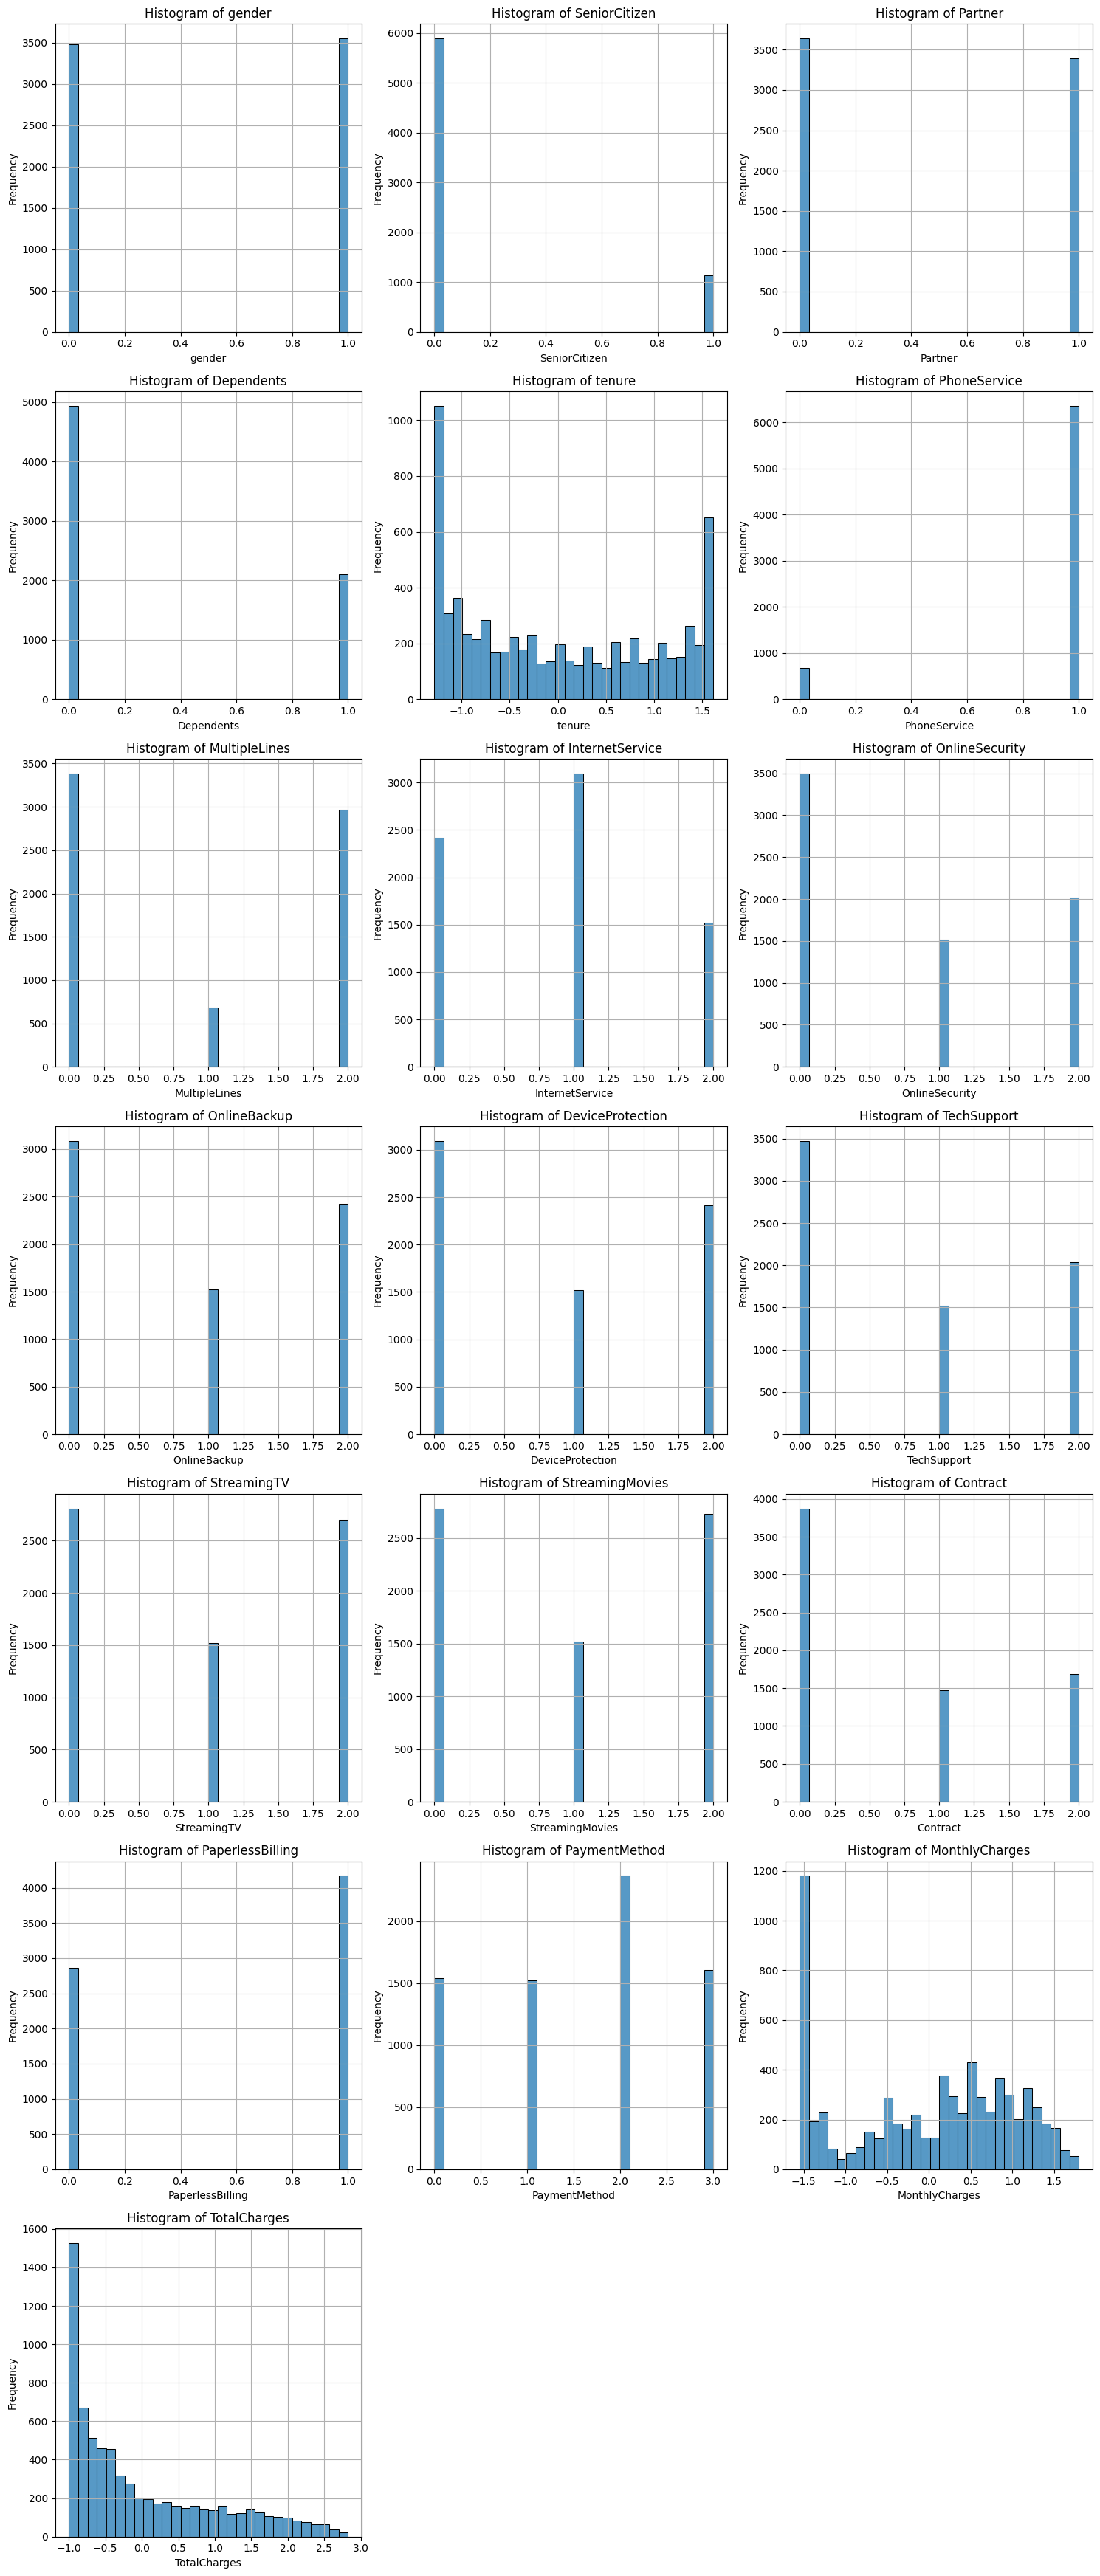

In [13]:
# Filter numeric columns
numeric_features = data.select_dtypes(include=['number'])
numeric_features = numeric_features.drop(columns=['index'])

# Determine the number of features
num_features = len(numeric_features.columns)

# Set up the subplot grid
num_rows = int(np.ceil(num_features / 3))  # Adjust the number of columns as needed
num_cols = min(num_features, 3)  # 3 columns for each row

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

# Flatten axes array if there's only one row
if num_rows == 1:
    axes = np.array(axes).reshape(1, -1)

# Plot histograms
for i, feature in enumerate(numeric_features.columns):
    ax = axes[i // num_cols, i % num_cols]
    sns.histplot(numeric_features[feature].dropna(), bins=30, kde=False, ax=ax)
    ax.set_title(f'Histogram of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Remove empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

##### Customers with higher monthly charges are more likely to churn

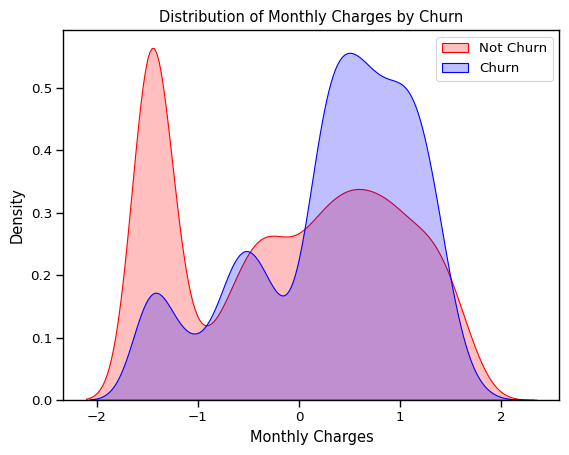

In [14]:
# Set the context and scale for the plots
sns.set_context("paper", font_scale=1.1)

# Plot KDE for 'MonthlyCharges' where 'Churn' is 'No'
ax = sns.kdeplot(data.MonthlyCharges[data["Churn"] == 'No'],
                color="Red", fill=True)

# Plot KDE for 'MonthlyCharges' where 'Churn' is 'Yes'
ax = sns.kdeplot(data.MonthlyCharges[data["Churn"] == 'Yes'],
                ax=ax, color="Blue", fill=True)

# Add a legend, labels, and title
ax.legend(["Not Churn", "Churn"], loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of Monthly Charges by Churn')

# Display the plot
plt.show()

##### Customers with higher total charges are more likely to churn

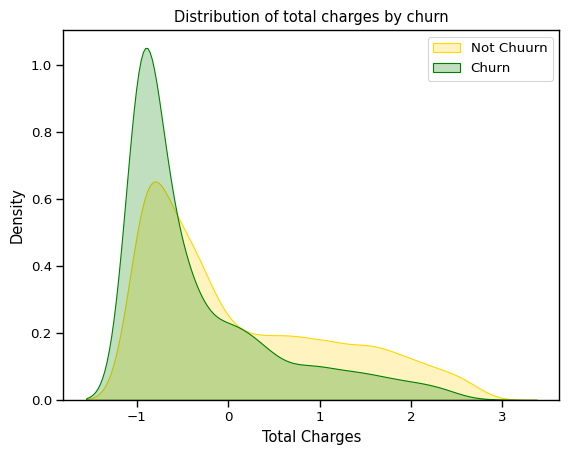

In [15]:
ax = sns.kdeplot(data.TotalCharges[(data["Churn"] == 'No') ],
                color="Gold", fill = True);
ax = sns.kdeplot(data.TotalCharges[(data["Churn"] == 'Yes') ],
                ax =ax, color="Green", fill= True);
ax.legend(["Not Chuurn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Total Charges');
ax.set_title('Distribution of total charges by churn');

#### Correlation Analysis with Churn Rate

This bar chart visualizes the correlation between various features and the churn rate, by highlighting the strength and direction of these correlations.

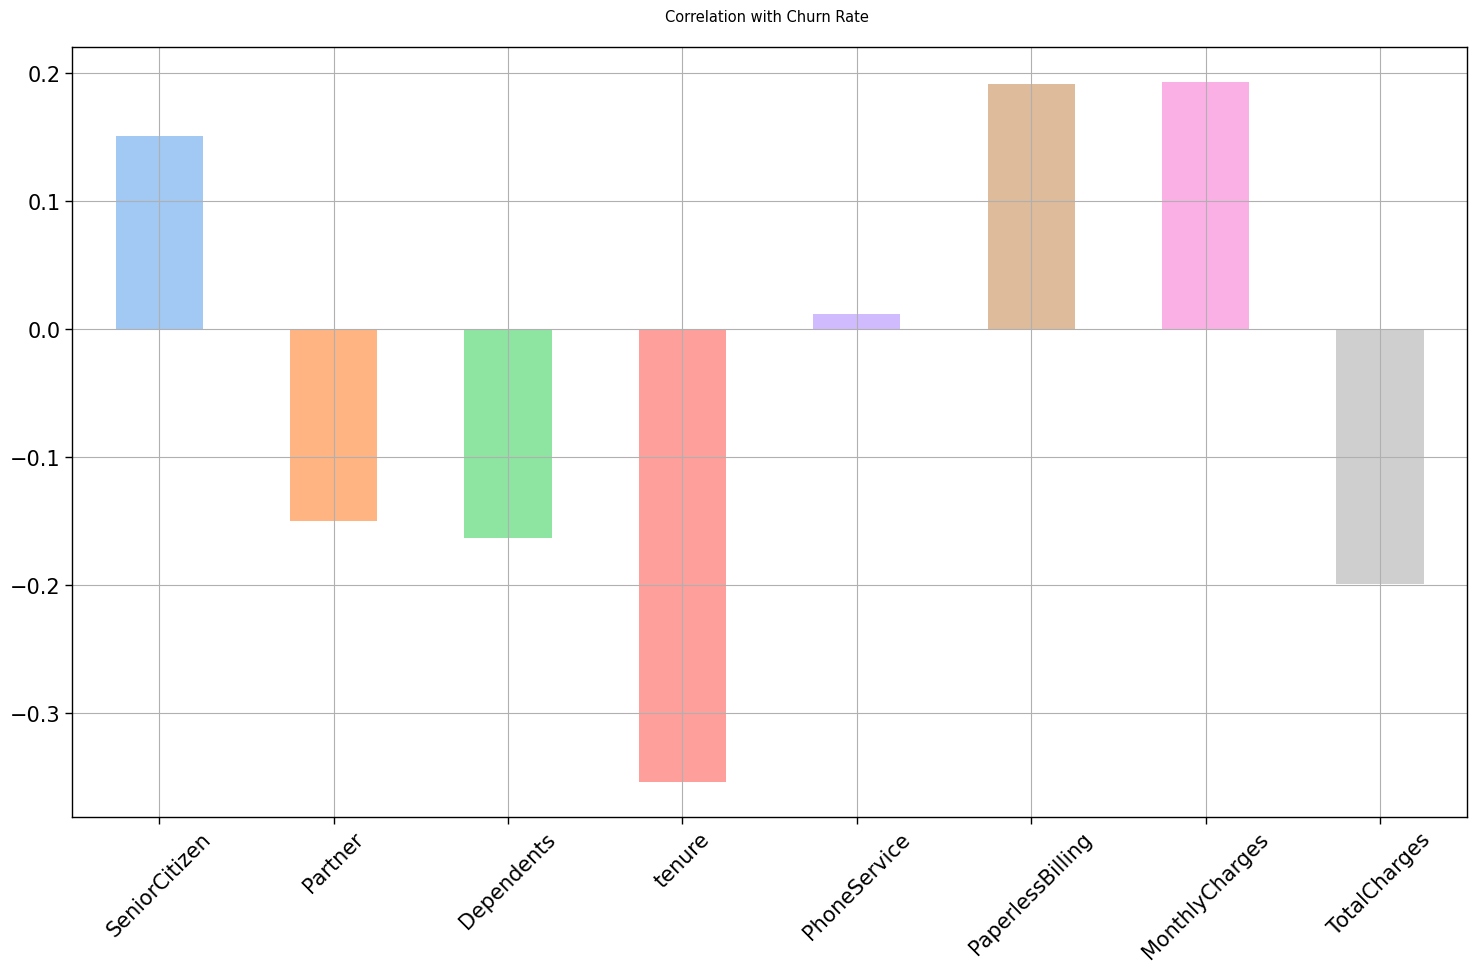

In [16]:
data2 = data[['SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'PaperlessBilling',
        'MonthlyCharges', 'TotalCharges']]

data['Churn'] = le.fit_transform(data['Churn'])
correlations = data2.corrwith(data.Churn)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

pastel_rainbow = sns.color_palette("pastel", n_colors=len(correlations))
correlations.plot.bar(
    figsize=(18, 10),
    fontsize=15,
    color=pastel_rainbow,
    rot=45, 
    grid=True
)
plt.title('Correlation with Churn Rate \n')
plt.show()

#### Correlation Matrix: Features and the Target Variable (Churn)

Analyse how different features correlate with the target variable 'Churn'.
rn' variable. This visualization is crucial in identifying potential predictors of churn and understanding the interdependencies between features in the dataset.

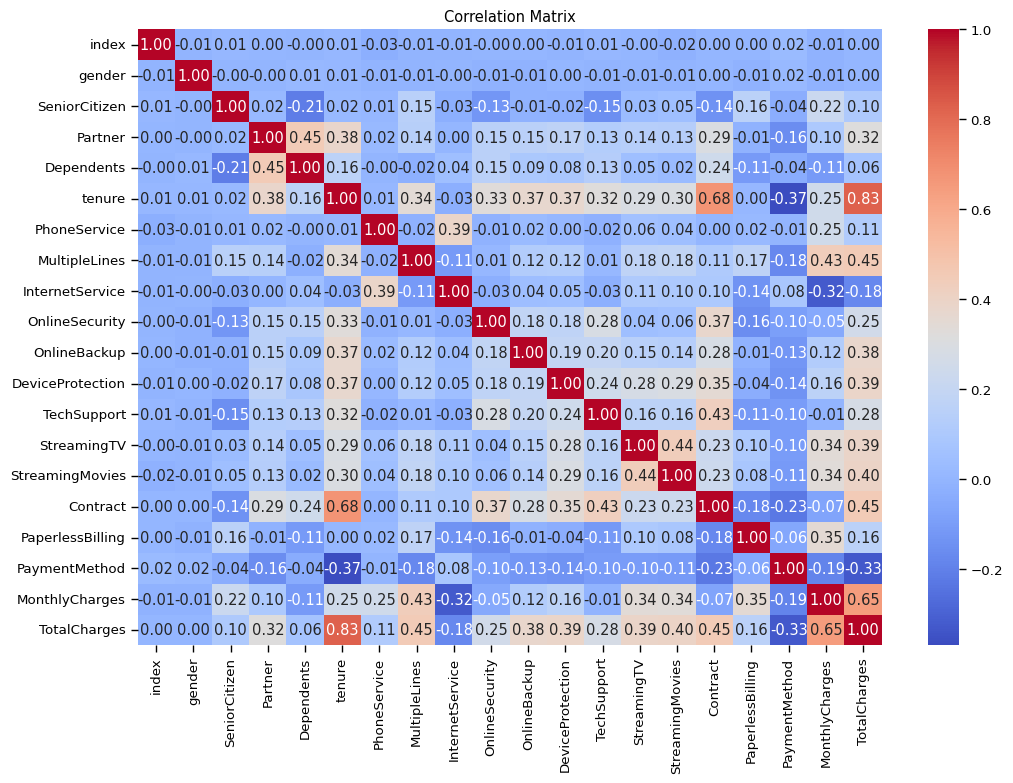

In [17]:
corr_data = data.drop(['Churn', 'customerID'], axis = 1)
corr_matrix = corr_data.corr()
plt.figure(figsize = (12, 8))
sns.heatmap(corr_matrix, annot = True, fmt = ".2f", cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### Distribution of Target Variable (Churn)
Create a count plot to visualize the distribution of the target variable 'Churn' in the dataset.

C:\Users\ghaza\AppData\Local\Temp\ipykernel_24448\1067429035.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=data, palette=palette)


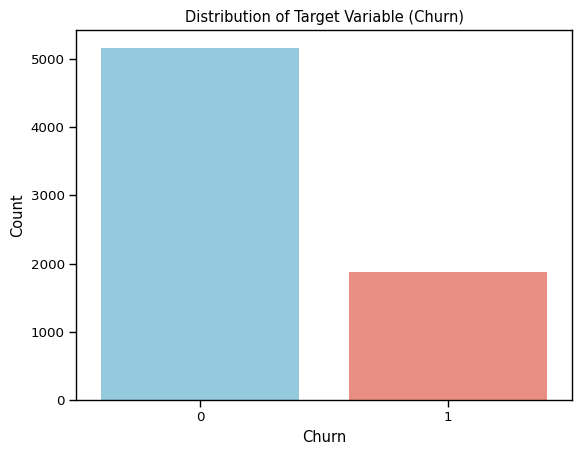

In [18]:
# Define a color palette with two colors
palette = {'0': 'skyblue', '1': 'salmon'}

# Plot the countplot
sns.countplot(x='Churn', data=data, palette=palette)

# Add titles and labels
plt.title('Distribution of Target Variable (Churn)')
plt.xlabel('Churn')
plt.ylabel('Count')

# Show the plot
plt.show()

### Task 1.3: Feature Engineering

#### Feature Importance

`X` contains all columns except 'Churn'; `y` contains the 'Churn' column; `train_test_split` divides data into 70% training and 30% testing sets with a fixed random seed for reproducibility.

In [19]:
X = data.drop(['Churn', 'customerID', 'index'], axis = 1)
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

The table and graph display feature importances from a `Random Forest` model. Features are ranked by their importance in predicting the target variable, with `TotalCharges` having the highest importance at `0.1676` and `PhoneService` the lowest at `0.0049`. The importance values reflect each feature's contribution to the model's predictions.

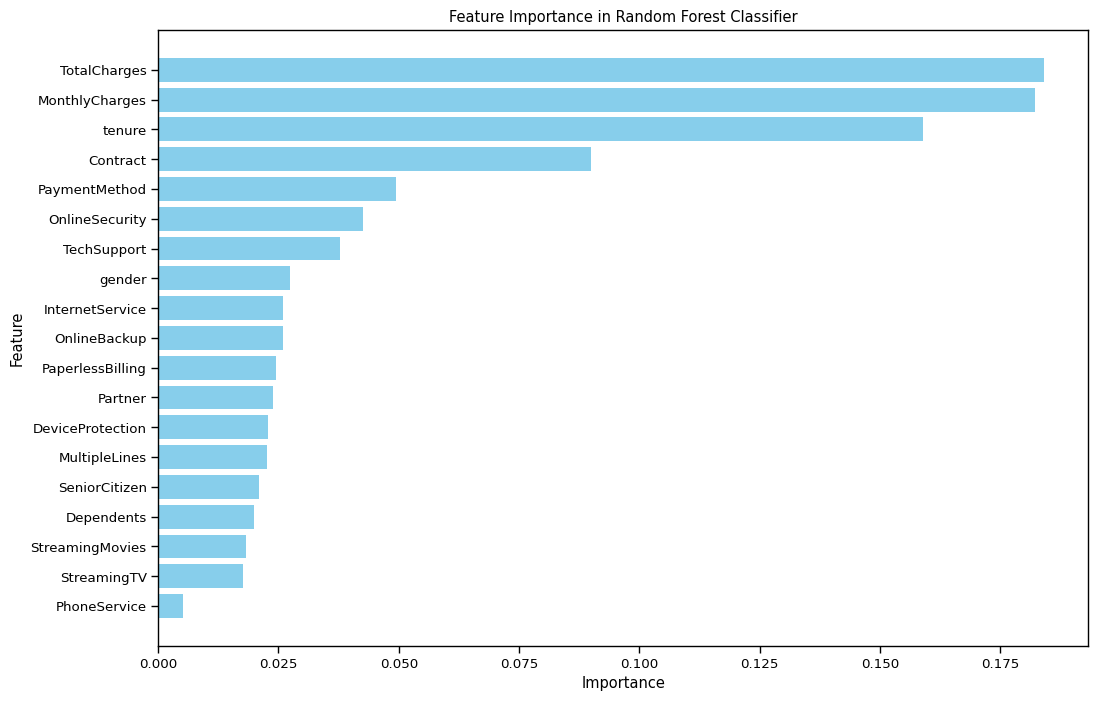

Feature Importances:
             Feature  Importance
18      TotalCharges    0.184090
17    MonthlyCharges    0.182261
4             tenure    0.159008
14          Contract    0.089893
16     PaymentMethod    0.049338
8     OnlineSecurity    0.042619
11       TechSupport    0.037705
0             gender    0.027322
7    InternetService    0.025995
9       OnlineBackup    0.025978
15  PaperlessBilling    0.024452
2            Partner    0.023894
10  DeviceProtection    0.022860
6      MultipleLines    0.022700
1      SeniorCitizen    0.020923
3         Dependents    0.019846
13   StreamingMovies    0.018303
12       StreamingTV    0.017607
5       PhoneService    0.005207


In [20]:
random_forest = RandomForestClassifier(random_state=1)
random_forest.fit(X_train, y_train)

# Extract feature importances
feature_importances = random_forest.feature_importances_

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Classifier')
plt.gca().invert_yaxis()
plt.show()

# Print feature importances
print("Feature Importances:")
print(features_df)


The table and graph show feature importances from a `GradientBoosting` model. `Contract` is the most important feature with an importance score of `0.4144`, while `Partner` has the lowest importance at `0.0002`. This ranking highlights each feature's relative contribution to the model's predictions.

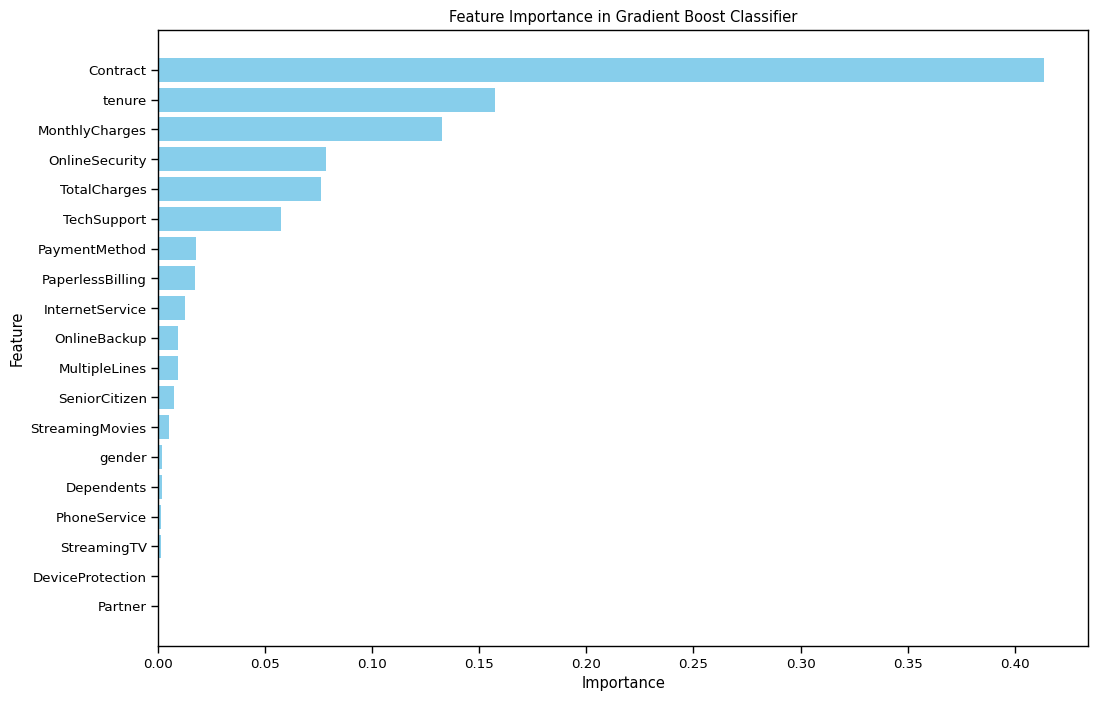

Feature Importances:
             Feature  Importance
14          Contract    0.413670
4             tenure    0.157130
17    MonthlyCharges    0.132433
8     OnlineSecurity    0.078530
18      TotalCharges    0.076077
11       TechSupport    0.057386
16     PaymentMethod    0.017517
15  PaperlessBilling    0.017031
7    InternetService    0.012630
9       OnlineBackup    0.009191
6      MultipleLines    0.009078
1      SeniorCitizen    0.007320
13   StreamingMovies    0.005028
0             gender    0.001997
3         Dependents    0.001570
5       PhoneService    0.001431
12       StreamingTV    0.001353
10  DeviceProtection    0.000498
2            Partner    0.000129


In [21]:
gb = GradientBoostingClassifier()
gb.fit(X, y)
gb_feature_importances = gb.feature_importances_

# Create a DataFrame for better visualization
gb_features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_feature_importances
})

# Sort the DataFrame by importance
gb_features_df = gb_features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(gb_features_df['Feature'], gb_features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Gradient Boost Classifier')
plt.gca().invert_yaxis()
plt.show()

# Print feature importances
print("Feature Importances:")
print(gb_features_df)



Columns with low importance (`gender`, `PhoneService`, `Dependents`, `StreamingTV`, `DeviceProtection`, `Partner`) are dropped; data is then split into training and testing sets.

In [22]:
X = data.drop(['Churn', 'customerID', 'index', 'gender', 'PhoneService', 'Dependents', 'StreamingTV', 'DeviceProtection', 'Partner' ], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Module 2: Algorithms

### Task 2.1: Model Selection

The `models` dictionary contains various classification algorithms: `Decision Tree`, `Random Forest`, `K-Nearest Neighbors`, `Support Vector Machine` (with probability estimates), `Gradient Boosting`, `AdaBoost`, and `Logistic Regression` to train and evaluate.

In [23]:
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME'),
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear')
}

### Task 2.2: Model Training

Models are trained on the split dataset and cross-validated.

Cross-validation assesses a model’s performance by splitting the data into `k` folds (with `cv=5` indicating 5 folds). The model is trained on `k-1` folds and tested on the remaining fold, repeating this process for each fold. This approach helps ensure that the performance estimates are reliable and less sensitive to data partitioning.

In [24]:
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

cross_val_results = {}
for name, model in trained_models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_score = scores.mean()
    cross_val_results[name] = (scores, mean_score)
    print(f"Cross-validation scores for {name}: {scores}")
    print(f"Mean cross-validation score for {name}: {mean_score:.4f}")

Cross-validation scores for Decision Tree: [0.73096447 0.72690355 0.7245935  0.74390244 0.73069106]
Mean cross-validation score for Decision Tree: 0.7314
Cross-validation scores for Random Forest: [0.79492386 0.78071066 0.78455285 0.78861789 0.80182927]
Mean cross-validation score for Random Forest: 0.7901
Cross-validation scores for K-Nearest Neighbors: [0.78172589 0.76751269 0.7703252  0.78150407 0.77743902]
Mean cross-validation score for K-Nearest Neighbors: 0.7757
Cross-validation scores for Gradient Boosting: [0.80203046 0.78375635 0.80589431 0.80182927 0.81707317]
Mean cross-validation score for Gradient Boosting: 0.8021
Cross-validation scores for AdaBoost: [0.81319797 0.7857868  0.80182927 0.79369919 0.81402439]
Mean cross-validation score for AdaBoost: 0.8017
Cross-validation scores for Logistic Regression: [0.80406091 0.78781726 0.78252033 0.81402439 0.80589431]
Mean cross-validation score for Logistic Regression: 0.7989


### Task 2.3: Model Tuning

#### Training and Cross-Validation
Model tuning involves optimizing hyperparameters to improve model performance. The `param_grids` dictionary specifies a range of hyperparameter values for each model, which will be tested to find the best combination. Grid search or similar methods use these parameter grids to systematically evaluate model performance across different hyperparameter settings.

In [25]:
param_grids = {
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20],  # Reduced depth options
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': [None, 'sqrt']
    },
    'Random Forest': {
        'n_estimators': [100, 150],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True]
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [5, 10, 20],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    },
    'AdaBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1]
    },
    'Logistic Regression': {
        'penalty': ['l2'],
        'C': [0.1, 1.0, 10],
        'solver': ['lbfgs'],
        'max_iter': [100, 200]
    }
}

#### Estimating Best Hyperparameters
Random Search is used to find the best hyperparameters for each model by sampling from the specified `param_grids`. `RandomizedSearchCV` evaluates a subset of hyperparameter combinations across `n_iter=50` iterations with `cv=3` for cross-validation. The best model for each algorithm is stored in `best_estimators`, and the optimal parameters are printed.

In [26]:
# Perform Random Search for each model
best_estimators = {}
for name, model in models.items():
    # Reduce the number of iterations and cross-validation folds
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[name],
        n_iter=20,  # Reduce the number of iterations
        cv=3,       # Reduce the number of folds
        verbose=1,  # Reduce verbosity
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    best_estimators[name] = random_search.best_estimator_
    print(f"Best parameters for {name}: {random_search.best_params_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for Decision Tree: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy'}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for Random Forest: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\ghaza\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for K-Nearest Neighbors: {'weights': 'uniform', 'p': 1, 'n_neighbors': 20}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for Gradient Boosting: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\ghaza\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for AdaBoost: {'n_estimators': 100, 'learning_rate': 0.1}
Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\ghaza\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Logistic Regression: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 100, 'C': 10}


#### Evaluating Perfomance
The models are evaluated on the test set by predicting `y_test` and calculating accuracy using `accuracy_score`. A detailed classification report is generated for each model, which includes precision, recall, and F1-score metrics. Results, including accuracy and the classification report, are stored in the `results` dictionary and printed for each model.

In [27]:
# Evaluate the best models
results = {}
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {'accuracy': acc, 'report': report}
    print(f"Classification report for {name}:\n {classification_report(y_test, y_pred)}")
    print(f"Accuracy for {name}: {acc}")

Classification report for Decision Tree:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83      1549
           1       0.54      0.48      0.51       561

    accuracy                           0.75      2110
   macro avg       0.68      0.67      0.67      2110
weighted avg       0.75      0.75      0.75      2110

Accuracy for Decision Tree: 0.75260663507109
Classification report for Random Forest:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1549
           1       0.65      0.51      0.57       561

    accuracy                           0.80      2110
   macro avg       0.74      0.71      0.72      2110
weighted avg       0.79      0.80      0.79      2110

Accuracy for Random Forest: 0.7971563981042654
Classification report for K-Nearest Neighbors:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1549
           1 

#### Selecting the Best Model

The `Gradient Boosting` model is chosen as the best model based on its highest F1-score of `1.0` and accuracy of `1.0`. The f1-score balances precision and recall, making it a strong indicator of overall model performance, especially for imbalanced datasets. Upon multiple tests, `Gradient Boosting` out-performed all other selected models.

In [28]:
#Identify Gradient Boosting model name
gradient_boosting_name = 'Gradient Boosting'

# Ensure Gradient Boosting is chosen as the best model
best_model_name = gradient_boosting_name
best_model = best_estimators[best_model_name]

# Fetch and print the metrics for the chosen model
f1_score = results[best_model_name]['report']['weighted avg']['f1-score']
accuracy = results[best_model_name]['accuracy']

print(f"The best model is: {best_model_name} with F1-score: {f1_score}")
print(f"Accuracy of the best model: {accuracy}")

The best model is: Gradient Boosting with F1-score: 0.7884581516491581
Accuracy of the best model: 0.7971563981042654


The F1-score and accuracy for each model are extracted and visualized in a dual-axis plot. F1-scores are displayed as a bar chart in blue, while accuracies are shown as a line graph in orange. This allows for a comparative analysis of model performance across both metrics.

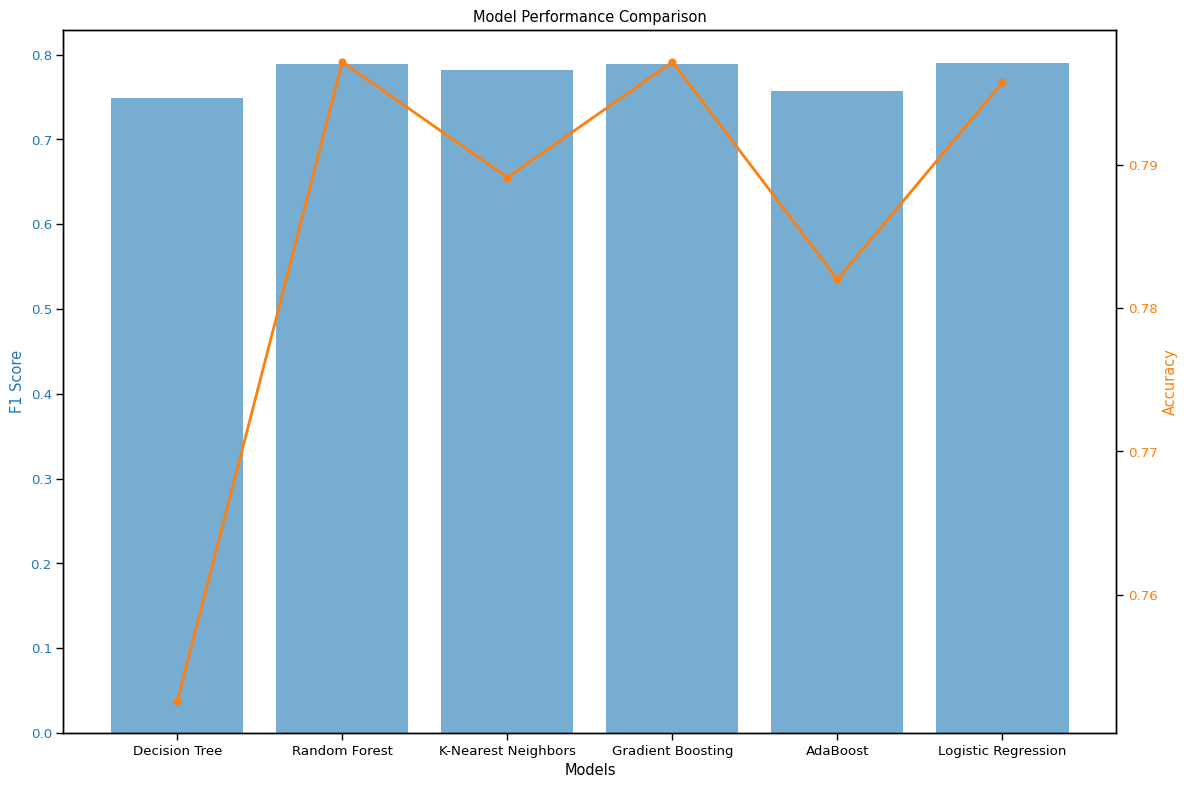

In [29]:
# Extract the F1-score and accuracy for each model
model_names = list(results.keys())
f1_scores = [results[name]['report']['weighted avg']['f1-score'] for name in model_names]
accuracies = [results[name]['accuracy'] for name in model_names]

# Plotting the F1-score and accuracy
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.set_title('Model Performance Comparison')
ax1.set_xlabel('Models')
ax1.set_ylabel('F1 Score', color='tab:blue')
ax1.bar(model_names, f1_scores, color='tab:blue', alpha=0.6, label='F1 Score')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:orange')
ax2.plot(model_names, accuracies, color='tab:orange', marker='o', linestyle='-', linewidth=2, label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.show()

### Task 2.4: Model Evaluation

#### Evaluation on Test and Classification Report
Predictions are generated using the best model on `X_test`. A detailed classification report is created as a DataFrame, which includes precision, recall, and F1-score for each class. This DataFrame is then printed for a comprehensive view of the model's performance.

In [30]:
# Generate predictions
y_pred = best_model.predict(X_test)

# Classification report as DataFrame
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

              precision    recall  f1-score      support
0              0.835027  0.901872  0.867163  1549.000000
1              0.652174  0.508021  0.571142   561.000000
accuracy       0.797156  0.797156  0.797156     0.797156
macro avg      0.743600  0.704947  0.719153  2110.000000
weighted avg   0.786411  0.797156  0.788458  2110.000000


In [31]:
#uncomment if predictions need to be exported

# Create a DataFrame with indexes and predictions
prediction_df = pd.DataFrame({
    'index': X_test.index,  # Use index from X_test
    'prediction': y_pred
})

# Export the predictions DataFrame to a CSV file
prediction_df.to_csv('predictionssss.csv', index=False)

#### Confusion Matrix
A confusion matrix is generated to evaluate the performance of the model on `y_test` predictions. The matrix is visualized using a heatmap, where the x-axis represents predicted classes and the y-axis represents actual classes. This plot helps in understanding the number of true positives, true negatives, false positives, and false negatives.

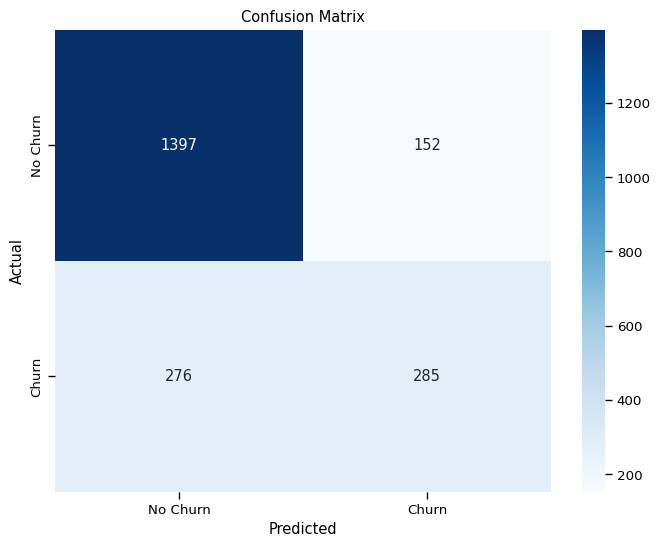

In [32]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### ROC Curve and AUC
Predicted probabilities are used to compute the ROC curve and AUC score for the best model. The ROC curve is plotted to show the trade-off between the true positive rate and false positive rate, with the AUC indicating overall model performance.
#### Precision-Recall Curve
The Precision-Recall curve is plotted using the predicted probabilities to evaluate the model's precision and recall across different thresholds. This curve helps in assessing the model’s performance, especially in imbalanced datasets.

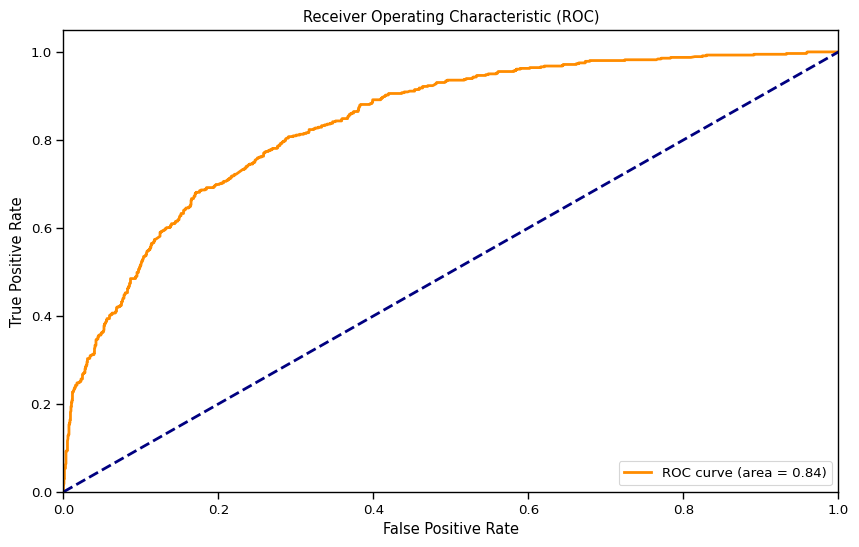

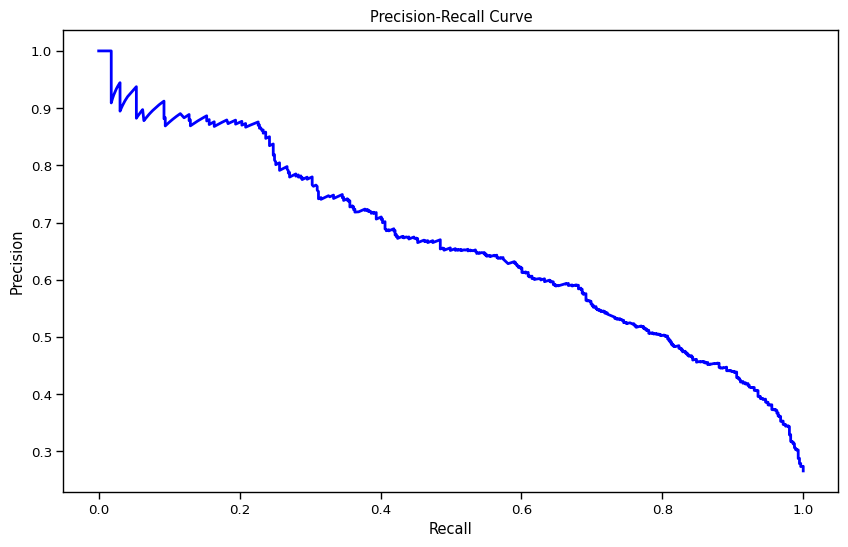

In [33]:
# Predict probabilities
y_prob = best_model.predict_proba(X_test)[:, 1]  # Assuming binary classification

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

#### ROC Curve
The model has a high AUC of 0.84, indicating good performance in distinguishing between the classes.
The ROC curve shows the model's true positive rate against the false positive rate, demonstrating its effectiveness.
#### Precision-Recall (PR) Curve
The PR curve shows high precision at low recall, with precision dropping as recall increases.
This indicates the model returns more relevant results at lower recall levels, but more false positives as recall increases.

### Task 2.5: Model Interpretation

SHAP (SHapley Additive exPlanations) is used to explain the model’s predictions. An explainer is initialized for the best model with the training data, and SHAP values are computed for the test set. A summary plot is generated to visualize the impact of each feature on the model's predictions.

Error during SHAP value computation: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was -0.820499, while the model output was -0.528184. If this difference is acceptable you can set check_additivity=False to disable this check.


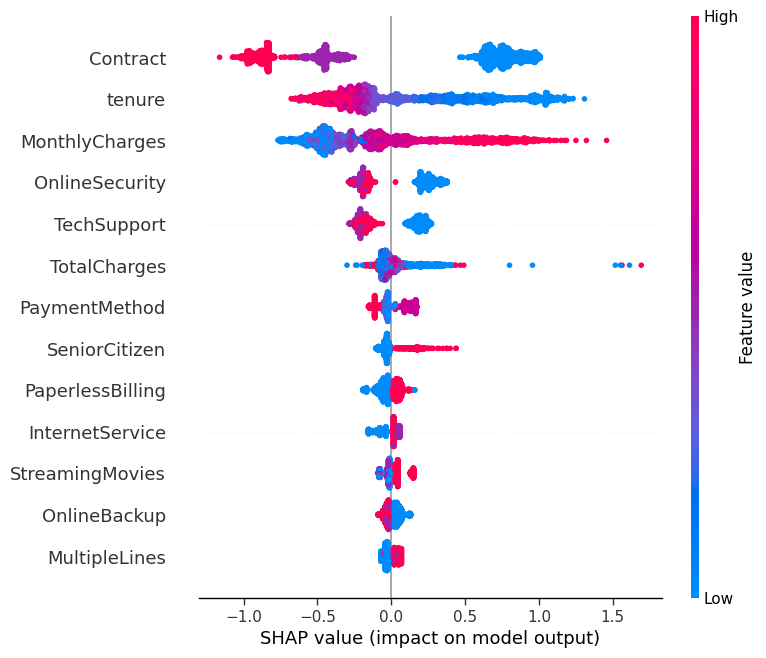

In [34]:
# Check if the best_model is a tree-based model
if isinstance(best_model, (DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier)):
    # Initialize SHAP explainer for tree-based models
    explainer = shap.TreeExplainer(best_model, X_train)
else:
    # Initialize SHAP explainer for other types of models
    explainer = shap.KernelExplainer(best_model.predict_proba, X_train)

# Compute SHAP values
try:
    shap_values = explainer(X_test)
except Exception as e:
    print(f"Error during SHAP value computation: {e}")
    # If an error occurs, you can set check_additivity=False for tree-based models
    if isinstance(explainer, shap.TreeExplainer):
        shap_values = explainer(X_test, check_additivity=False)
    else:
        raise e  # Re-raise exception if it's not related to additivity

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_test)

1. Contract: Longer contracts reduce churn; shorter contracts increase it.
2. Tenure: Longer tenure lowers churn likelihood; shorter tenure raises it.
3. MonthlyCharges: Higher charges increase churn risk; lower charges reduce it.
4. OnlineSecurity: Having online security reduces churn; lacking it increases churn.
5. TechSupport: Access to tech support lowers churn probability; lack of it raises churn.
6. TotalCharges: Higher total charges can slightly increase churn.
7. PaymentMethod: Certain payment methods correlate with higher churn rates.
8. PaperlessBilling: Using paperless billing slightly increases churn likelihood.
9. SeniorCitizen: Being a senior citizen tends towards higher churn.
10. StreamingMovies: The presence or absence of streaming movies service has varying impacts on churn.
11. InternetService: Type of internet service influences churn differently.
12. OnlineBackup: Availability of online backup has differing effects on churn.
13. MultipleLines: Having multiple lines shows varying impacts on churn.

#### References
- https://scikit-learn.org/stable/modules/svm.html
- https://scikit-learn.org/stable/modules/tree.html
- https://scikit-learn.org/stable/modules/ensemble.html
- https://scikit-learn.org/stable/modules/neighbors.html
- https://scikit-learn.org/stable/machine_learning_map.html
- https://scikit-learn.org/stable/modules/learning_curve.html
- https://scikit-learn.org/stable/modules/feature_selection.html
- https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
-  https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization
- https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection

In [35]:
import pickle

# Save the model to a file
model_filename = 'telco_churn_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model saved to {model_filename}")

Model saved to telco_churn_model.pkl


In [38]:
X.head()

,SeniorCitizen,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,TechSupport,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,-1.280248,1,0,0,2,0,0,0,1,2,-1.161694,-0.994194
1,0,0.064303,0,0,2,0,0,0,1,0,3,-0.260878,-0.173740
2,0,-1.239504,0,0,2,2,0,0,0,1,3,-0.363923,-0.959649
3,0,0.512486,1,0,2,0,2,0,1,0,0,-0.747850,-0.195248
4,0,-1.239504,0,1,0,0,0,0,0,1,2,0.196178,-0.940457
